<a href="https://colab.research.google.com/github/Aman-Singh-Akhand/QML-HEP-GSoC-2025/blob/main/Task_IX_Kolmogorov_Arnold_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class ClassicalKANLayer(nn.Module):
    def __init__(self, num_inputs, num_knots=10):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_knots = num_knots

        # knots are not trainable, fixed grid
        self.register_buffer("knots", torch.linspace(-1.5, 1.5, num_knots))

        # trainable spline coefficients for each input dim
        self.coeffs = nn.Parameter(torch.randn(num_inputs, num_knots))

    def forward(self, x):
        # x shape: (batch_size, num_inputs)
        device = x.device

        # ensure coeffs is on the same device
        coeffs = self.coeffs.to(device)
        knots = self.knots.to(device)

        # normalize x into the spline range
        x_exp = x.unsqueeze(-1)  # (batch_size, num_inputs, 1)

        idx = ((x_exp - (-1.5)) / (3.0 / (self.num_knots - 1))).long()
        idx = torch.clamp(idx, 0, self.num_knots - 2)  # (batch_size, num_inputs, 1)

        # gather left and right knots
        left_knot = knots[idx]                   # (batch_size, num_inputs, 1)
        right_knot = knots[idx + 1]              # (batch_size, num_inputs, 1)

        # interpolation weight
        weight = (x_exp - left_knot) / (right_knot - left_knot)

        # gather spline coeffs for interpolation
        # reshape coeffs for broadcasting: (1, num_inputs, num_knots)
        batch_size = x.shape[0]
        coeffs = coeffs.unsqueeze(0).expand(batch_size, -1, -1)

        idx = idx.squeeze(-1)  # (batch_size, num_inputs)
        coeff_left = torch.gather(coeffs, 2, idx.unsqueeze(-1)).squeeze(-1)
        coeff_right = torch.gather(coeffs, 2, (idx + 1).unsqueeze(-1)).squeeze(-1)

        out = (1 - weight.squeeze(-1)) * coeff_left + weight.squeeze(-1) * coeff_right
        return out


class KAN(nn.Module):
    def __init__(self):
        super(KAN, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.spline1 = ClassicalKANLayer(128)
        self.fc2 = nn.Linear(128, 64)
        self.spline2 = ClassicalKANLayer(64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.spline1(x)
        x = self.fc2(x)
        x = self.spline2(x)
        x = self.fc3(x)
        return x



In [ ]:
# Load MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = datasets.MNIST(root='.', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='.', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000)


In [ ]:
num_epochs = 10
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        _, predicted = outputs.max(1)
        total += y.size(0)
        correct += predicted.eq(y).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = 100. * correct / total

    # Evaluate on test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            _, predicted = outputs.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()
    test_acc = 100. * correct / total

    # Save metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")


Epoch 1/10 | Train Loss: 0.1334 | Train Acc: 95.91% | Test Acc: 95.62%
Epoch 2/10 | Train Loss: 0.1257 | Train Acc: 96.19% | Test Acc: 95.61%
Epoch 3/10 | Train Loss: 0.1200 | Train Acc: 96.38% | Test Acc: 95.77%
Epoch 4/10 | Train Loss: 0.1078 | Train Acc: 96.71% | Test Acc: 95.49%
Epoch 5/10 | Train Loss: 0.1020 | Train Acc: 96.90% | Test Acc: 96.34%
Epoch 6/10 | Train Loss: 0.0945 | Train Acc: 97.07% | Test Acc: 95.99%
Epoch 7/10 | Train Loss: 0.0959 | Train Acc: 96.98% | Test Acc: 96.10%
Epoch 8/10 | Train Loss: 0.0879 | Train Acc: 97.22% | Test Acc: 96.01%
Epoch 9/10 | Train Loss: 0.0829 | Train Acc: 97.43% | Test Acc: 96.11%
Epoch 10/10 | Train Loss: 0.0807 | Train Acc: 97.41% | Test Acc: 97.11%


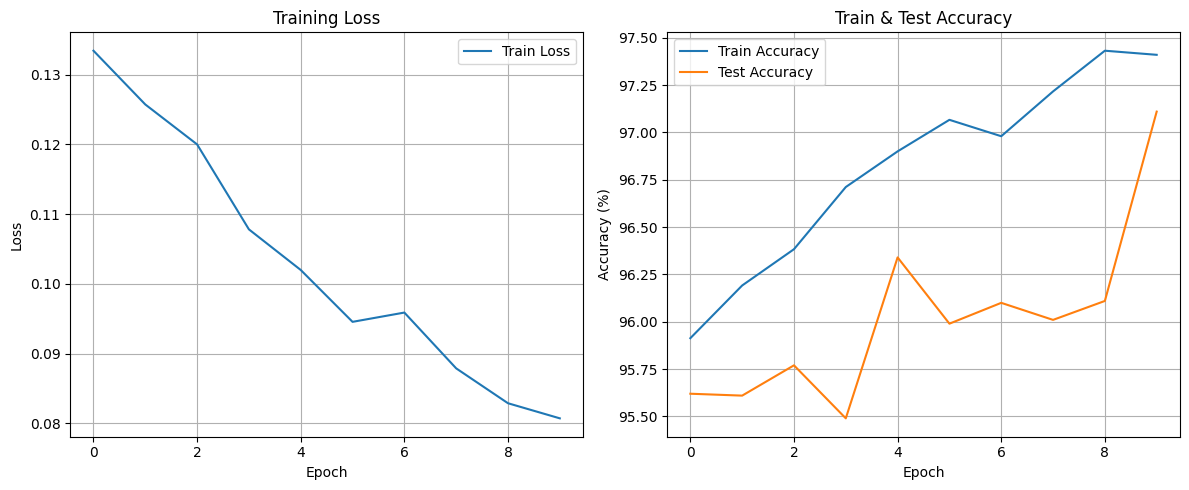

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train & Test Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Evaluate
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        correct += (pred.argmax(1) == y).sum().item()
        total += y.size(0)
print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 97.11%


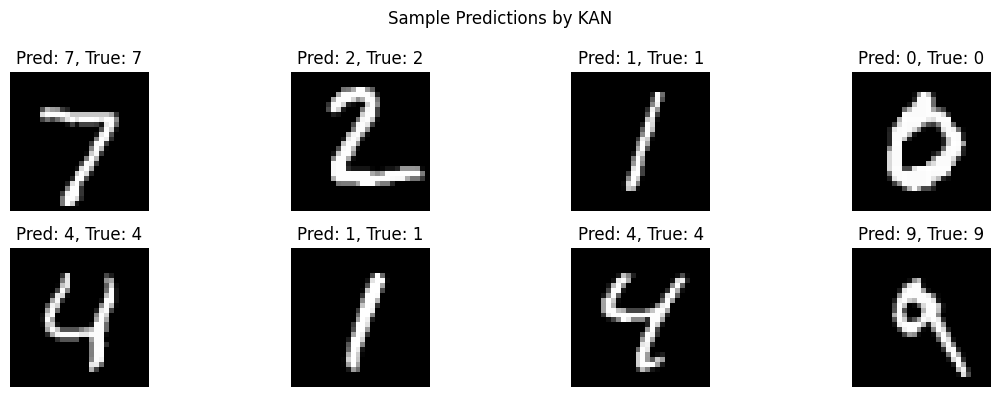

In [ ]:
import matplotlib.pyplot as plt

model.eval()
examples = iter(test_loader)
images, labels = next(examples)
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Plot first 8 predictions
plt.figure(figsize=(12, 4))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i].cpu().squeeze(), cmap='gray')
    plt.title(f"Pred: {predicted[i].item()}, True: {labels[i].item()}")
    plt.axis('off')
plt.suptitle("Sample Predictions by KAN")
plt.tight_layout()
plt.show()


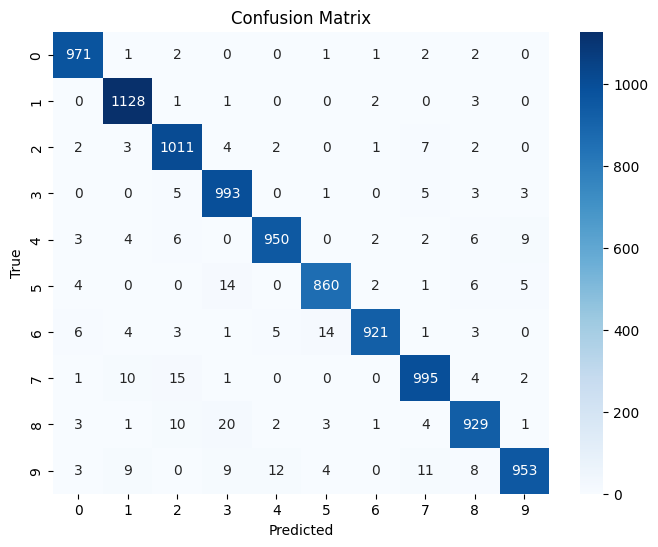

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Collect predictions on test set
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


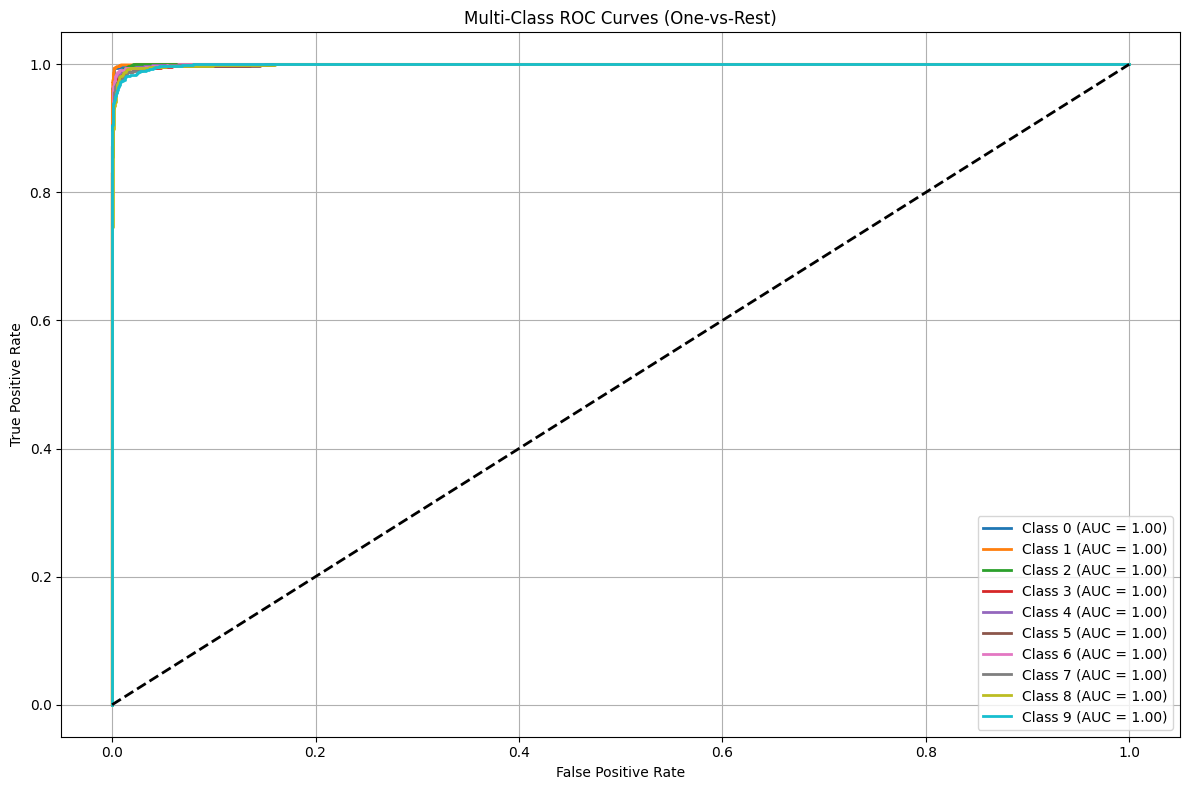

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Get predictions and probabilities
model.eval()
y_true = []
y_scores = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        outputs = model(x)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        y_scores.extend(probs)
        y_true.extend(y.numpy())

y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Binarize the true labels for multiclass ROC
y_true_bin = label_binarize(y_true, classes=np.arange(10))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(12, 8))
for i in range(10):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
# Save only the model weights (recommended)
torch.save(model.state_dict(), 'kan_mnist_weights.pth')


# qKAN
The Quantum Kolmogorov-Arnold Network (qKAN) is the quantum version of a KAN where classical splines have been substituted for quantum circuits and gates.
Through the use of quantum computation, qKAN can achieve far more powerful non-linear transformations and optimization, especially in high dimension. But, quantum noise and hardware limitations still remain as one of the obstacles.

First the data is needed to be embedded in the Hilbert Space of qubits and then fed into the quantum network to carry out the task. A basic architecture of qKAN is shown below:
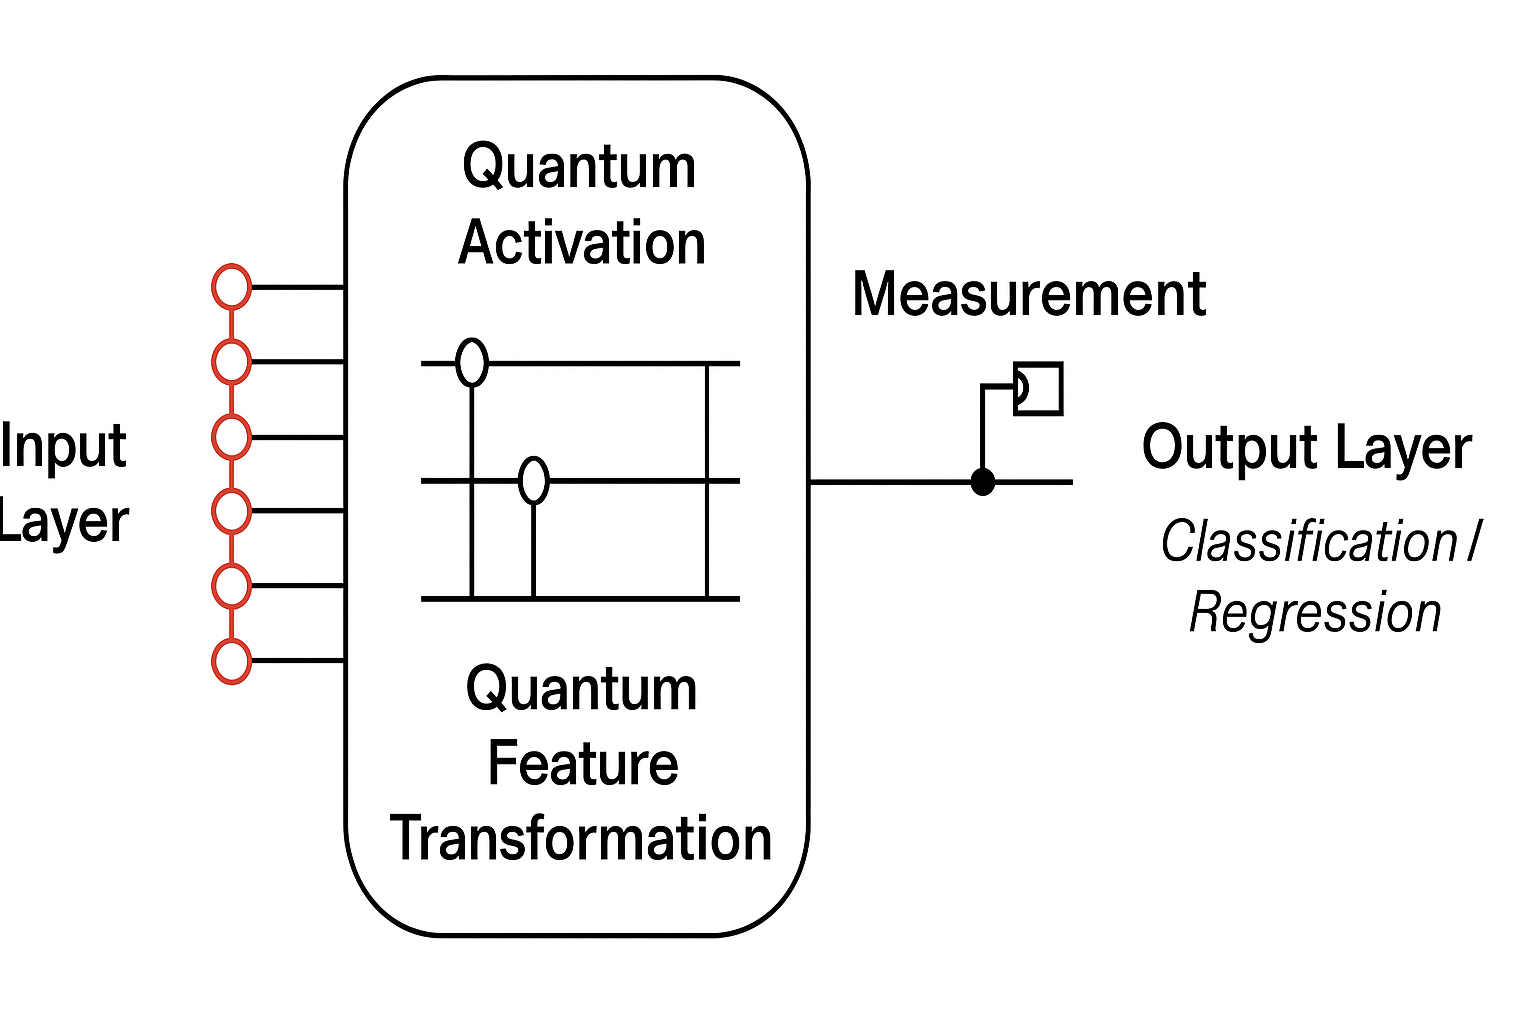